In [1]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm


from source import run_single_experiment, display_top_f1_scores

pd.options.display.max_rows = 999
plt.style.use('fivethirtyeight')

# Task: predict very low popularity trakcs on `Spotify` based on audio features

This is a notebook for the [blog post](http://blog.vaidasarmonas.tech/http://blog.vaidasarmonas.tech/machine-learning-design-patterns-problem-representation-part-2.html). The main idea is to investigate Machine Learning Design Patterns described in [this](https://www.oreilly.com/library/view/machine-learning-design/9781098115777/) book. This ispecific notebook is investigation of two design patterns - **Rebalancing** and **Ensembles**. 

Data was downloaded from [Kaggle](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks) and you can find a description of this dataset there.

## Load data and quick EDA

In [2]:
data = pd.read_csv("./spotify_track_features_data.csv")

In [3]:
data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [4]:
data_last_decade = data[data["year"] >= 2011]
print(f"Total tracks from the last decadelen: {len(data_last_decade)}")

Total tracks from the last decadelen: 19788


Split our dataset to train/test data before moving forward

In [5]:
AUDIO_FEATURES = [
    "valence",
    "acousticness",
    "danceability",
    "energy",
    "explicit",
    "instrumentalness",
    "key",
    "liveness",
    "mode",
    "speechiness",
    "tempo",
]
TARGET = "popularity"

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_last_decade[AUDIO_FEATURES], data_last_decade[TARGET], test_size=0.2, random_state=42)

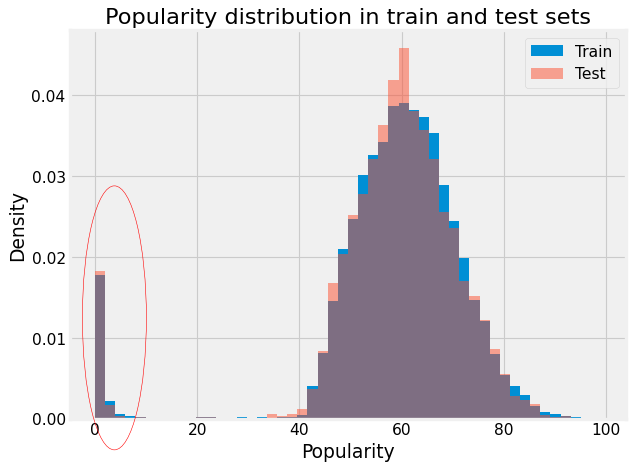

In [7]:
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_, bins, _ = plt.hist(y_train.to_list(), bins=50, density=True, label="Train")
_ = plt.hist(y_test.to_list(), bins=bins, alpha=0.5, density=True, label="Test")
e = Ellipse(xy=(0.15,0.28), width=0.1, height=0.55)
e.set_edgecolor("red")
e.set_facecolor("none")
e.set_alpha(1)
fig.add_artist(e)
_ = plt.title("Popularity distribution in train and test sets")
_ = plt.xlabel("Popularity")
_ = plt.ylabel("Density")
_ = plt.legend()

In [8]:
y_train.describe()

count    15830.000000
mean        58.889071
std         15.300208
min          0.000000
25%         54.000000
50%         61.000000
75%         67.000000
max         99.000000
Name: popularity, dtype: float64

In [9]:
y_test.describe()

count    3958.000000
mean       58.576554
std        15.135913
min         0.000000
25%        53.000000
50%        60.000000
75%        67.000000
max       100.000000
Name: popularity, dtype: float64

In [10]:
y_train[y_train <= 20].describe()

count    671.000000
mean       0.873323
std        2.506181
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       20.000000
Name: popularity, dtype: float64

In [11]:
y_train[y_train > 20].describe()

count    15159.000000
mean        61.457088
std          9.412284
min         21.000000
25%         55.000000
50%         61.000000
75%         68.000000
max         99.000000
Name: popularity, dtype: float64

In [12]:
# Preparing alternative targets for classification
y_train_low_pop = (y_train <= 20).astype(float)
y_test_low_pop = (y_test <= 20).astype(float)

print(f"Frequency of low popularity songs in train set: {y_train_low_pop.mean():.4f}")
print(f"Frequency of low popularity songs in test set: {y_test_low_pop.mean():.4f}")

Frequency of low popularity songs in train set: 0.0424
Frequency of low popularity songs in test set: 0.0414


In [13]:
y_train_low_pop.describe()

count    15830.000000
mean         0.042388
std          0.201479
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: popularity, dtype: float64

In [14]:
y_test_low_pop.describe()

count    3958.000000
mean        0.041435
std         0.199319
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: popularity, dtype: float64

# Modeling

Let us investigate different approaches to predict low popularity tracks. We will approach this as a highly imbalanced classification problem and will attempt to solve it with [Naive Classification](#naive_classifcation), [Different Class Weights](#class_weighing), [Random Undersampling](#random_udersampling), [NearMiss Undersampling](#nearmiss_undersampling), [SMOTE Oversampling](#SMOTE_oversampling), [ADASYN Oversampling](#ADASYN_oversampling), and [Ensemble](#ensemble).

You can skip to [results](#results) if you want to see which of the above approaches worked best in our case.

## Naive Classification <a id='naive_classification'>

In [15]:
naive_classifier = GradientBoostingClassifier().fit(X_train, y_train_low_pop)
preds = naive_classifier.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test_low_pop, preds)

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    f1score = 2 * (precision * recall) / (precision + recall)

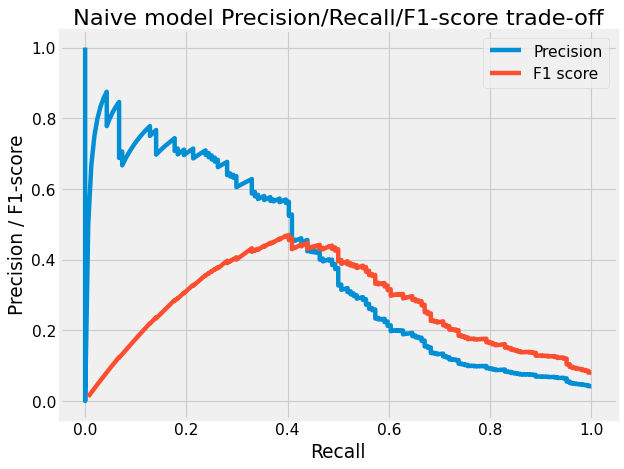

In [17]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_ = plt.plot(recall, precision, label='Precision')
_ = plt.plot(recall, f1score, label="F1 score")
_ = plt.xlabel("Recall")
_ = plt.ylabel("Precision / F1-score")
_ = plt.title("Naive model Precision/Recall/F1-score trade-off")
_ = plt.legend()

In [18]:
display_top_f1_scores(precision, recall, f1score, thresholds)

,Precision,Recall,F1-score,Threshold
3621,0.564103,0.402439,0.469751,0.205428
3620,0.559322,0.402439,0.468085,0.203382
3624,0.570175,0.396341,0.467626,0.214832
3619,0.554622,0.402439,0.466431,0.200889
3623,0.565217,0.396341,0.465950,0.208310


The best `threshold` is `0.205` with `precision` of `0.564` and `recall` of `0.402`. The corresponding `f1-score` is `0.470`.

## Different class weights <a id='class_weighing'>

In [19]:
from sklearn.utils.class_weight import compute_sample_weight

In [20]:
class_weights_results = {}
for weight in tqdm(range(1, 15)):
    print(f"Running for minority weight input: {weight}")
    adjusted_weights = compute_sample_weight({0: 1, 1: weight}, y_train_low_pop)
    print(f"Actual weights - majority: {min(adjusted_weights)}; minority: {max(adjusted_weights)}")
    cls = GradientBoostingClassifier().fit(X_train, y_train_low_pop, adjusted_weights)
    preds = cls.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test_low_pop, preds)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        f1score = 2 * (precision * recall) / (precision + recall)
    
    display_top_f1_scores(precision, recall, f1score, thresholds)
    
    class_weights_results[weight] = {
        "cls": cls,
        "recall": recall,
        "precision": precision,
        "f1": f1score,
    }
    print()

  0%|          | 0/14 [00:00<?, ?it/s]

Running for minority weight input: 1
Actual weights - majority: 1.0; minority: 1.0


,Precision,Recall,F1-score,Threshold
3622,0.564103,0.402439,0.469751,0.205428
3621,0.559322,0.402439,0.468085,0.203382
3625,0.570175,0.396341,0.467626,0.214832
3620,0.554622,0.402439,0.466431,0.200889
3624,0.565217,0.396341,0.465950,0.208310



Running for minority weight input: 2
Actual weights - majority: 1.0; minority: 2.0


,Precision,Recall,F1-score,Threshold
3492,0.565217,0.396341,0.465950,0.346663
3496,0.576577,0.390244,0.465455,0.356860
3491,0.560345,0.396341,0.464286,0.338706
3495,0.571429,0.390244,0.463768,0.356090
3490,0.555556,0.396341,0.462633,0.335123



Running for minority weight input: 3
Actual weights - majority: 1.0; minority: 3.0


,Precision,Recall,F1-score,Threshold
3614,0.500000,0.451220,0.474359,0.333486
3613,0.496644,0.451220,0.472843,0.330595
3605,0.481013,0.463415,0.472050,0.317116
3612,0.493333,0.451220,0.471338,0.326419
3604,0.477987,0.463415,0.470588,0.316182



Running for minority weight input: 4
Actual weights - majority: 1.0; minority: 4.0


,Precision,Recall,F1-score,Threshold
3494,0.523810,0.402439,0.455172,0.481804
3473,0.479730,0.432927,0.455128,0.402078
3490,0.511450,0.408537,0.454237,0.459036
3472,0.476510,0.432927,0.453674,0.399558
3489,0.507576,0.408537,0.452703,0.446667



Running for minority weight input: 5
Actual weights - majority: 1.0; minority: 5.0


,Precision,Recall,F1-score,Threshold
3459,0.514706,0.426829,0.466667,0.472775
3450,0.496552,0.439024,0.466019,0.444874
3458,0.510949,0.426829,0.465116,0.471251
3449,0.493151,0.439024,0.464516,0.443111
3440,0.477419,0.451220,0.463950,0.430361



Running for minority weight input: 6
Actual weights - majority: 1.0; minority: 6.0


,Precision,Recall,F1-score,Threshold
3530,0.496689,0.457317,0.476190,0.476495
3529,0.493421,0.457317,0.474684,0.476386
3528,0.487013,0.457317,0.471698,0.472489
3531,0.493333,0.451220,0.471338,0.481339
3527,0.483871,0.457317,0.470219,0.468371



Running for minority weight input: 7
Actual weights - majority: 1.0; minority: 7.0


,Precision,Recall,F1-score,Threshold
3459,0.524476,0.457317,0.488599,0.545446
3458,0.520833,0.457317,0.487013,0.533943
3457,0.517241,0.457317,0.485437,0.533571
3456,0.513699,0.457317,0.483871,0.532221
3460,0.521127,0.451220,0.483660,0.556385



Running for minority weight input: 8
Actual weights - majority: 1.0; minority: 8.0


,Precision,Recall,F1-score,Threshold
3506,0.480263,0.445122,0.462025,0.555020
3501,0.471338,0.451220,0.461059,0.544332
3514,0.493056,0.432927,0.461039,0.578523
3505,0.477124,0.445122,0.460568,0.552088
3509,0.483221,0.439024,0.460064,0.560225



Running for minority weight input: 9
Actual weights - majority: 1.0; minority: 9.0


,Precision,Recall,F1-score,Threshold
3583,0.556452,0.420732,0.479167,0.654138
3582,0.552000,0.420732,0.477509,0.650390
3581,0.547619,0.420732,0.475862,0.650230
3585,0.557377,0.414634,0.475524,0.654293
3593,0.578947,0.402439,0.474820,0.679351



Running for minority weight input: 10
Actual weights - majority: 1.0; minority: 10.0


,Precision,Recall,F1-score,Threshold
3539,0.534884,0.420732,0.470990,0.652159
3538,0.530769,0.420732,0.469388,0.651543
3537,0.526718,0.420732,0.467797,0.651171
3536,0.522727,0.420732,0.466216,0.650372
3535,0.518797,0.420732,0.464646,0.650278



Running for minority weight input: 11
Actual weights - majority: 1.0; minority: 11.0


,Precision,Recall,F1-score,Threshold
3524,0.467456,0.481707,0.474474,0.589570
3523,0.464706,0.481707,0.473054,0.589239
3535,0.481013,0.463415,0.472050,0.606193
3522,0.461988,0.481707,0.471642,0.589214
3526,0.467066,0.475610,0.471299,0.593567



Running for minority weight input: 12
Actual weights - majority: 1.0; minority: 12.0


,Precision,Recall,F1-score,Threshold
3677,0.490196,0.457317,0.473186,0.636389
3681,0.496644,0.451220,0.472843,0.645395
3685,0.503448,0.445122,0.472492,0.658195
3676,0.487013,0.457317,0.471698,0.636333
3680,0.493333,0.451220,0.471338,0.640810



Running for minority weight input: 13
Actual weights - majority: 1.0; minority: 13.0


,Precision,Recall,F1-score,Threshold
3607,0.515152,0.414634,0.459459,0.686929
3606,0.511278,0.414634,0.457912,0.685984
3610,0.519380,0.408537,0.457338,0.699004
3605,0.507463,0.414634,0.456376,0.685638
3609,0.515385,0.408537,0.455782,0.689731



Running for minority weight input: 14
Actual weights - majority: 1.0; minority: 14.0


,Precision,Recall,F1-score,Threshold
3510,0.515152,0.414634,0.459459,0.715255
3509,0.511278,0.414634,0.457912,0.714273
3508,0.507463,0.414634,0.456376,0.707671
3490,0.473684,0.439024,0.455696,0.683038
3507,0.503704,0.414634,0.454849,0.707389


We made an improvement with the weighting of the minority class variables selecting weight as `7-to-1`.
Results of the best threshold (`0.545`): Precision - `0.524`; Recall - `0.457`; F1 - `0.489`

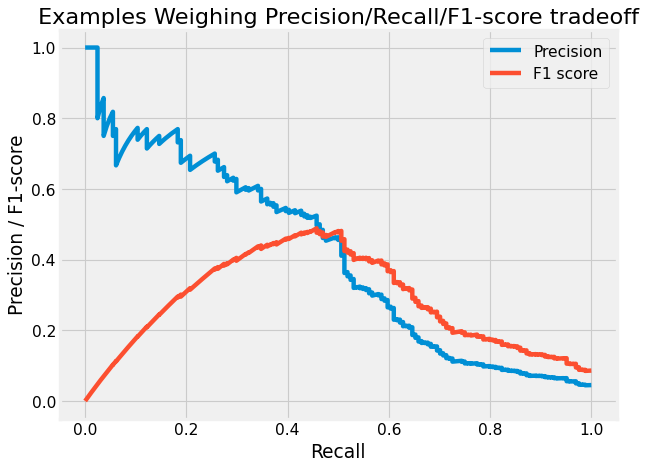

In [21]:
plot_precision = class_weights_results[7]["precision"]
plot_recall = class_weights_results[7]["recall"]
plot_f1 = class_weights_results[7]["f1"]

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_ = plt.plot(plot_recall, plot_precision, label="Precision")
_ = plt.plot(plot_recall, plot_f1, label="F1 score")
_ = plt.xlabel("Recall")
_ = plt.ylabel("Precision / F1-score")
_ = plt.title("Examples Weighing Precision/Recall/F1-score tradeoff")
_ = plt.legend()

## Random Undersampling <a id='random_udersampling'>

In [22]:
from imblearn.under_sampling import RandomUnderSampler

In [23]:
random_sample_models = {}
for sampling_strategy in tqdm([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]):
    print(f"Running for sampling strategy: {sampling_strategy}")
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
    cls, precision, recall, f1 = run_single_experiment(rus, X_train, y_train_low_pop, X_test, y_test_low_pop)
    random_sample_models[sampling_strategy] = {
        "cls": cls,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
    print()

  0%|          | 0/9 [00:00<?, ?it/s]

Running for sampling strategy: 0.1


,Precision,Recall,F1-score,Threshold
3683,0.452941,0.469512,0.461078,0.269092
3661,0.427083,0.500000,0.460674,0.236465
3682,0.450292,0.469512,0.459701,0.266230
3660,0.424870,0.500000,0.459384,0.235921
3681,0.447674,0.469512,0.458333,0.263809



Running for sampling strategy: 0.15


,Precision,Recall,F1-score,Threshold
3617,0.467456,0.481707,0.474474,0.368524
3616,0.464706,0.481707,0.473054,0.367923
3615,0.461988,0.481707,0.471642,0.364586
3614,0.459302,0.481707,0.470238,0.362618
3613,0.456647,0.481707,0.468843,0.360063



Running for sampling strategy: 0.2


,Precision,Recall,F1-score,Threshold
3521,0.465909,0.500000,0.482353,0.423348
3520,0.463277,0.500000,0.480938,0.422345
3519,0.460674,0.500000,0.479532,0.419675
3541,0.496732,0.463415,0.479495,0.471987
3518,0.458101,0.500000,0.478134,0.419542



Running for sampling strategy: 0.25


,Precision,Recall,F1-score,Threshold
3572,0.496732,0.463415,0.479495,0.526930
3571,0.493506,0.463415,0.477987,0.525041
3567,0.484277,0.469512,0.476780,0.521715
3566,0.481250,0.469512,0.475309,0.521065
3570,0.487179,0.463415,0.475000,0.524474



Running for sampling strategy: 0.3


,Precision,Recall,F1-score,Threshold
3441,0.463415,0.463415,0.463415,0.566152
3440,0.460606,0.463415,0.462006,0.565728
3439,0.457831,0.463415,0.460606,0.562337
3443,0.462963,0.457317,0.460123,0.568118
3438,0.455090,0.463415,0.459215,0.561050



Running for sampling strategy: 0.35


,Precision,Recall,F1-score,Threshold
3434,0.441860,0.463415,0.452381,0.598309
3426,0.430939,0.475610,0.452174,0.583000
3468,0.496350,0.414634,0.451827,0.650715
3429,0.435028,0.469512,0.451613,0.588964
3460,0.479452,0.426829,0.451613,0.644752



Running for sampling strategy: 0.4


,Precision,Recall,F1-score,Threshold
3565,0.472222,0.414634,0.441558,0.659277
3601,0.555556,0.365854,0.441176,0.739718
3596,0.539823,0.371951,0.440433,0.725987
3605,0.567308,0.359756,0.440299,0.745093
3600,0.550459,0.365854,0.439560,0.737629



Running for sampling strategy: 0.45


,Precision,Recall,F1-score,Threshold
3456,0.484848,0.390244,0.432432,0.700778
3455,0.481203,0.390244,0.430976,0.699875
3464,0.500000,0.378049,0.430556,0.712585
3473,0.521739,0.365854,0.430108,0.738097
3454,0.477612,0.390244,0.429530,0.697293



Running for sampling strategy: 0.5


,Precision,Recall,F1-score,Threshold
3397,0.485075,0.396341,0.436242,0.734163
3396,0.481481,0.396341,0.434783,0.730646
3391,0.471429,0.402439,0.434211,0.725472
3395,0.477941,0.396341,0.433333,0.729814
3390,0.468085,0.402439,0.432787,0.723931


The best moddel was trained on the data that was "balanced" to the `20%` mark.
Results of the best threshold (`0.423`): Precision - `0.469`; Recall - `0.500`; F1 - `0.484`

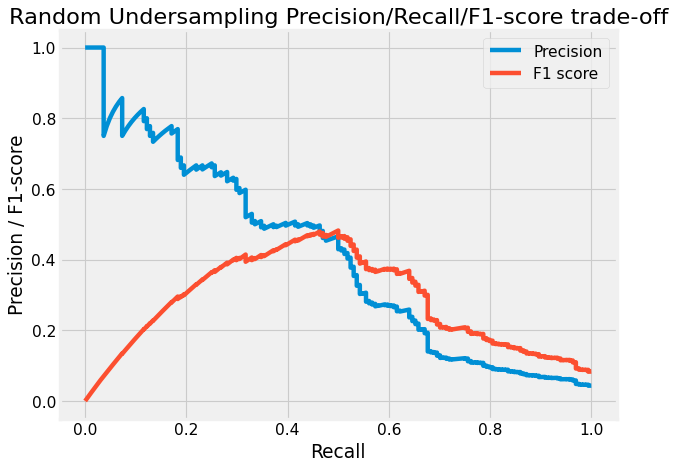

In [24]:
plot_precision = random_sample_models[0.2]["precision"]
plot_recall = random_sample_models[0.2]["recall"]
plot_f1 = random_sample_models[0.2]["f1"]

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_ = plt.plot(plot_recall, plot_precision, label="Precision")
_ = plt.plot(plot_recall, plot_f1, label="F1 score")
_ = plt.xlabel("Recall")
_ = plt.ylabel("Precision / F1-score")
_ = plt.title("Random Undersampling Precision/Recall/F1-score trade-off")
_ = plt.legend()

## Smart undersampling - NearMiss <a id='nearmiss_undersampling'>

In [25]:
from imblearn.under_sampling import NearMiss

In [26]:
near_miss_models = {}
for near_miss_version in tqdm(range(1, 4)):
    for sampling_strategy in tqdm([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]):
        print(f"Running for NearMiss version: {near_miss_version} & sampling strategy: {sampling_strategy}")
        nm = NearMiss(sampling_strategy=sampling_strategy, version=near_miss_version)
        cls, precision, recall, f1 = run_single_experiment(nm, X_train, y_train_low_pop, X_test, y_test_low_pop)
        near_miss_models[f"{near_miss_version}_{sampling_strategy}"] = {
            "cls": cls,
            "precision": precision,
            "recall": recall,
            "f1": f1,
        }
        print()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Running for NearMiss version: 1 & sampling strategy: 0.1


,Precision,Recall,F1-score,Threshold
3287,0.214765,0.390244,0.277056,0.472908
3279,0.212418,0.396341,0.276596,0.465195
3286,0.214047,0.390244,0.276458,0.472066
3278,0.211726,0.396341,0.276008,0.463482
3285,0.213333,0.390244,0.275862,0.472007



Running for NearMiss version: 1 & sampling strategy: 0.15


,Precision,Recall,F1-score,Threshold
3211,0.195195,0.396341,0.261569,0.538627
3210,0.194611,0.396341,0.261044,0.537073
3209,0.194030,0.396341,0.260521,0.534465
3201,0.192420,0.402439,0.260355,0.526525
3208,0.193452,0.396341,0.260000,0.533211



Running for NearMiss version: 1 & sampling strategy: 0.2


,Precision,Recall,F1-score,Threshold
3298,0.164619,0.408537,0.234676,0.592673
3306,0.165414,0.402439,0.234458,0.596175
3297,0.164216,0.408537,0.234266,0.590862
3305,0.165000,0.402439,0.234043,0.594893
3296,0.163814,0.408537,0.233857,0.590212



Running for NearMiss version: 1 & sampling strategy: 0.25


,Precision,Recall,F1-score,Threshold
3612,0.187793,0.243902,0.212202,0.801863
3296,0.138577,0.451220,0.212034,0.571057
3295,0.138318,0.451220,0.211731,0.569965
3277,0.137184,0.463415,0.211699,0.560663
3611,0.186916,0.243902,0.211640,0.799279



Running for NearMiss version: 1 & sampling strategy: 0.3


,Precision,Recall,F1-score,Threshold
3409,0.148230,0.408537,0.217532,0.673004
3408,0.147903,0.408537,0.217180,0.672976
3407,0.147577,0.408537,0.216828,0.672570
3406,0.147253,0.408537,0.216478,0.672478
3405,0.146930,0.408537,0.216129,0.671854



Running for NearMiss version: 1 & sampling strategy: 0.35


,Precision,Recall,F1-score,Threshold
3508,0.152000,0.347561,0.211503,0.775503
3507,0.151596,0.347561,0.211111,0.774650
3506,0.151194,0.347561,0.210721,0.773363
3505,0.150794,0.347561,0.210332,0.772825
3504,0.150396,0.347561,0.209945,0.772643



Running for NearMiss version: 1 & sampling strategy: 0.4


,Precision,Recall,F1-score,Threshold
3539,0.158501,0.335366,0.215264,0.823533
3538,0.158046,0.335366,0.214844,0.823221
3537,0.157593,0.335366,0.214425,0.822556
3536,0.157143,0.335366,0.214008,0.822031
3535,0.156695,0.335366,0.213592,0.822031



Running for NearMiss version: 1 & sampling strategy: 0.45


,Precision,Recall,F1-score,Threshold
3450,0.149425,0.396341,0.217028,0.821797
3449,0.149083,0.396341,0.216667,0.821312
3448,0.148741,0.396341,0.216306,0.820984
3447,0.148402,0.396341,0.215947,0.820411
3446,0.148064,0.396341,0.215589,0.820250



Running for NearMiss version: 1 & sampling strategy: 0.5


,Precision,Recall,F1-score,Threshold
3574,0.157895,0.310976,0.209446,0.882595
3573,0.157407,0.310976,0.209016,0.882423
3572,0.156923,0.310976,0.208589,0.881840
3571,0.156442,0.310976,0.208163,0.881835
3570,0.155963,0.310976,0.207739,0.881565


  0%|          | 0/9 [00:00<?, ?it/s]

Running for NearMiss version: 2 & sampling strategy: 0.1


,Precision,Recall,F1-score,Threshold
1023,0.058948,0.847561,0.110230,0.056270
1022,0.058923,0.847561,0.110186,0.056073
1021,0.058898,0.847561,0.110143,0.056019
1020,0.058873,0.847561,0.110099,0.055582
1019,0.058848,0.847561,0.110055,0.055564



Running for NearMiss version: 2 & sampling strategy: 0.15


,Precision,Recall,F1-score,Threshold
458,0.049076,0.939024,0.093277,0.037113
436,0.049051,0.945122,0.093261,0.035873
457,0.049060,0.939024,0.093249,0.037085
435,0.049035,0.945122,0.093233,0.035871
456,0.049045,0.939024,0.093220,0.037021



Running for NearMiss version: 2 & sampling strategy: 0.2


,Precision,Recall,F1-score,Threshold
490,0.046732,0.902439,0.088862,0.058173
489,0.046717,0.902439,0.088836,0.058053
488,0.046702,0.902439,0.088809,0.057900
487,0.046688,0.902439,0.088782,0.057787
486,0.046673,0.902439,0.088756,0.057663



Running for NearMiss version: 2 & sampling strategy: 0.25


,Precision,Recall,F1-score,Threshold
3377,0.210000,0.128049,0.159091,0.990835
3376,0.207921,0.128049,0.158491,0.990832
3375,0.205882,0.128049,0.157895,0.990785
3374,0.203883,0.128049,0.157303,0.990778
3373,0.201923,0.128049,0.156716,0.990721



Running for NearMiss version: 2 & sampling strategy: 0.3


,Precision,Recall,F1-score,Threshold
3625,0.250000,0.091463,0.133929,0.995048
3624,0.245902,0.091463,0.133333,0.994968
3549,0.145985,0.121951,0.132890,0.993054
3623,0.241935,0.091463,0.132743,0.994945
3548,0.144928,0.121951,0.132450,0.992994



Running for NearMiss version: 2 & sampling strategy: 0.35


,Precision,Recall,F1-score,Threshold
3386,0.148571,0.158537,0.153392,0.992571
3385,0.147727,0.158537,0.152941,0.992554
3398,0.153374,0.152439,0.152905,0.992824
3384,0.146893,0.158537,0.152493,0.992540
3397,0.152439,0.152439,0.152439,0.992802



Running for NearMiss version: 2 & sampling strategy: 0.4


,Precision,Recall,F1-score,Threshold
3335,0.248447,0.243902,0.246154,0.993766
3334,0.246914,0.243902,0.245399,0.993765
3333,0.245399,0.243902,0.244648,0.993761
3332,0.243902,0.243902,0.243902,0.993752
3331,0.240964,0.243902,0.242424,0.993725



Running for NearMiss version: 2 & sampling strategy: 0.45


,Precision,Recall,F1-score,Threshold
3418,0.198830,0.207317,0.202985,0.994818
3417,0.197674,0.207317,0.202381,0.994814
3416,0.196532,0.207317,0.201780,0.994807
3328,0.163498,0.262195,0.201405,0.993497
3415,0.195402,0.207317,0.201183,0.994766



Running for NearMiss version: 2 & sampling strategy: 0.5


,Precision,Recall,F1-score,Threshold
3390,0.277311,0.20122,0.233216,0.995868
3389,0.275000,0.20122,0.232394,0.995849
3388,0.272727,0.20122,0.231579,0.995842
3387,0.270492,0.20122,0.230769,0.995785
3386,0.268293,0.20122,0.229965,0.995772


  0%|          | 0/9 [00:00<?, ?it/s]

Running for NearMiss version: 3 & sampling strategy: 0.1


/Users/vaidas/.pyenv/versions/datascience/lib/python3.6/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


,Precision,Recall,F1-score,Threshold
3669,0.408163,0.365854,0.385852,0.646502
3668,0.405405,0.365854,0.384615,0.642928
3667,0.402685,0.365854,0.383387,0.641713
3666,0.400000,0.365854,0.382166,0.640650
3681,0.422222,0.347561,0.381271,0.662706



Running for NearMiss version: 3 & sampling strategy: 0.15


/Users/vaidas/.pyenv/versions/datascience/lib/python3.6/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


,Precision,Recall,F1-score,Threshold
3671,0.413793,0.365854,0.388350,0.646502
3670,0.410959,0.365854,0.387097,0.642928
3669,0.408163,0.365854,0.385852,0.641713
3668,0.405405,0.365854,0.384615,0.640650
3683,0.428571,0.347561,0.383838,0.662706



Running for NearMiss version: 3 & sampling strategy: 0.2


/Users/vaidas/.pyenv/versions/datascience/lib/python3.6/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


,Precision,Recall,F1-score,Threshold
3668,0.405405,0.365854,0.384615,0.646502
3667,0.402685,0.365854,0.383387,0.642928
3666,0.400000,0.365854,0.382166,0.641713
3681,0.422222,0.347561,0.381271,0.662706
3665,0.397351,0.365854,0.380952,0.640650



Running for NearMiss version: 3 & sampling strategy: 0.25


/Users/vaidas/.pyenv/versions/datascience/lib/python3.6/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


,Precision,Recall,F1-score,Threshold
3670,0.413793,0.365854,0.388350,0.646502
3669,0.410959,0.365854,0.387097,0.644872
3668,0.408163,0.365854,0.385852,0.642928
3667,0.405405,0.365854,0.384615,0.641713
3666,0.402685,0.365854,0.383387,0.640650



Running for NearMiss version: 3 & sampling strategy: 0.3


/Users/vaidas/.pyenv/versions/datascience/lib/python3.6/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


,Precision,Recall,F1-score,Threshold
3669,0.408163,0.365854,0.385852,0.646502
3668,0.405405,0.365854,0.384615,0.642928
3667,0.402685,0.365854,0.383387,0.641713
3682,0.425373,0.347561,0.382550,0.662706
3666,0.400000,0.365854,0.382166,0.640650



Running for NearMiss version: 3 & sampling strategy: 0.35


/Users/vaidas/.pyenv/versions/datascience/lib/python3.6/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


,Precision,Recall,F1-score,Threshold
3669,0.410959,0.365854,0.387097,0.646502
3668,0.408163,0.365854,0.385852,0.642928
3667,0.405405,0.365854,0.384615,0.641713
3682,0.428571,0.347561,0.383838,0.662706
3666,0.402685,0.365854,0.383387,0.640650



Running for NearMiss version: 3 & sampling strategy: 0.4


/Users/vaidas/.pyenv/versions/datascience/lib/python3.6/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


,Precision,Recall,F1-score,Threshold
3667,0.408163,0.365854,0.385852,0.646502
3666,0.405405,0.365854,0.384615,0.642928
3665,0.402685,0.365854,0.383387,0.641713
3664,0.400000,0.365854,0.382166,0.640650
3679,0.422222,0.347561,0.381271,0.662706



Running for NearMiss version: 3 & sampling strategy: 0.45


/Users/vaidas/.pyenv/versions/datascience/lib/python3.6/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


,Precision,Recall,F1-score,Threshold
3669,0.408163,0.365854,0.385852,0.646502
3668,0.405405,0.365854,0.384615,0.642928
3667,0.402685,0.365854,0.383387,0.641713
3682,0.425373,0.347561,0.382550,0.662706
3666,0.400000,0.365854,0.382166,0.640650



Running for NearMiss version: 3 & sampling strategy: 0.5


,Precision,Recall,F1-score,Threshold
3714,0.479339,0.353659,0.407018,0.689462
3709,0.468254,0.359756,0.406897,0.675820
3713,0.475410,0.353659,0.405594,0.689246
3708,0.464567,0.359756,0.405498,0.672985
3712,0.471545,0.353659,0.404181,0.689229


The best moddel was trained on the data that was "balanced" (50/50) and used algorithm version 3.
Results of the best threshold (`0.692`): Precision - `0.483`; Recall - `0.341`; F1 - `0.400`

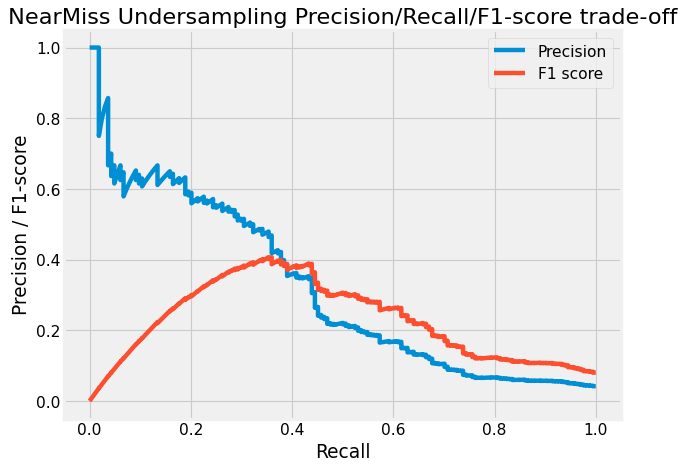

In [27]:
plot_precision = near_miss_models["3_0.5"]["precision"]
plot_recall = near_miss_models["3_0.5"]["recall"]
plot_f1 = near_miss_models["3_0.5"]["f1"]

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_ = plt.plot(plot_recall, plot_precision, label="Precision")
_ = plt.plot(plot_recall, plot_f1, label="F1 score")
_ = plt.xlabel("Recall")
_ = plt.ylabel("Precision / F1-score")
_ = plt.title("NearMiss Undersampling Precision/Recall/F1-score trade-off")
_ = plt.legend()

## Oversampling - SMOTE <a id='SMOTE_oversampling'>

In [28]:
from imblearn.over_sampling import SMOTE

In [29]:
smote_models = {}
for smote_ratio in tqdm([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]):
    print(f"Running for SMOTE ratio: {smote_ratio}")
    smote = SMOTE(sampling_strategy=smote_ratio, random_state=42)
    cls, precision, recall, f1 = run_single_experiment(smote, X_train, y_train_low_pop, X_test, y_test_low_pop)
    smote_models[smote_ratio] = {
        "cls": cls,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
    print()

  0%|          | 0/9 [00:00<?, ?it/s]

Running for SMOTE ratio: 0.1


,Precision,Recall,F1-score,Threshold
3559,0.463087,0.420732,0.440895,0.346252
3563,0.468966,0.414634,0.440129,0.366051
3558,0.460000,0.420732,0.439490,0.344179
3562,0.465753,0.414634,0.438710,0.354944
3557,0.456954,0.420732,0.438095,0.341176



Running for SMOTE ratio: 0.15


,Precision,Recall,F1-score,Threshold
3625,0.460000,0.420732,0.439490,0.457229
3633,0.475177,0.408537,0.439344,0.474859
3629,0.465753,0.414634,0.438710,0.469520
3624,0.456954,0.420732,0.438095,0.451411
3632,0.471831,0.408537,0.437908,0.472407



Running for SMOTE ratio: 0.2


,Precision,Recall,F1-score,Threshold
3650,0.500000,0.396341,0.442177,0.566813
3645,0.488889,0.402439,0.441472,0.553519
3640,0.478571,0.408537,0.440789,0.544639
3649,0.496183,0.396341,0.440678,0.560537
3644,0.485294,0.402439,0.440000,0.552072



Running for SMOTE ratio: 0.25


,Precision,Recall,F1-score,Threshold
3551,0.478261,0.402439,0.437086,0.600774
3562,0.504000,0.384146,0.435986,0.621847
3571,0.525862,0.371951,0.435714,0.646792
3550,0.474820,0.402439,0.435644,0.599231
3566,0.512397,0.378049,0.435088,0.632060



Running for SMOTE ratio: 0.3


,Precision,Recall,F1-score,Threshold
3474,0.452055,0.402439,0.425806,0.622341
3478,0.457746,0.396341,0.424837,0.629503
3473,0.448980,0.402439,0.424437,0.617812
3517,0.560000,0.341463,0.424242,0.723115
3482,0.463768,0.390244,0.423841,0.637060



Running for SMOTE ratio: 0.35


,Precision,Recall,F1-score,Threshold
3365,0.467626,0.396341,0.429043,0.681203
3355,0.449664,0.408537,0.428115,0.668071
3364,0.464286,0.396341,0.427632,0.679927
3354,0.446667,0.408537,0.426752,0.667422
3363,0.460993,0.396341,0.426230,0.679380



Running for SMOTE ratio: 0.4


,Precision,Recall,F1-score,Threshold
3610,0.448980,0.402439,0.424437,0.687584
3609,0.445946,0.402439,0.423077,0.684094
3608,0.442953,0.402439,0.421725,0.682336
3612,0.448276,0.396341,0.420712,0.688745
3607,0.440000,0.402439,0.420382,0.681496



Running for SMOTE ratio: 0.45


,Precision,Recall,F1-score,Threshold
3598,0.451389,0.396341,0.422078,0.721901
3597,0.448276,0.396341,0.420712,0.720715
3614,0.484127,0.371951,0.420690,0.751097
3609,0.473282,0.378049,0.420339,0.742870
3628,0.517857,0.353659,0.420290,0.781412



Running for SMOTE ratio: 0.5


,Precision,Recall,F1-score,Threshold
3661,0.430464,0.396341,0.412698,0.719347
3656,0.420382,0.402439,0.411215,0.705736
3676,0.458647,0.371951,0.410774,0.741181
3660,0.424837,0.396341,0.410095,0.714939
3655,0.417722,0.402439,0.409938,0.703593


The best model was trained on the data that was "balanced" to the `20%` mark.
Results of the best threshold (`0.567`): Precision - `0.500`; Recall - `0.396`; F1 - `0.442`

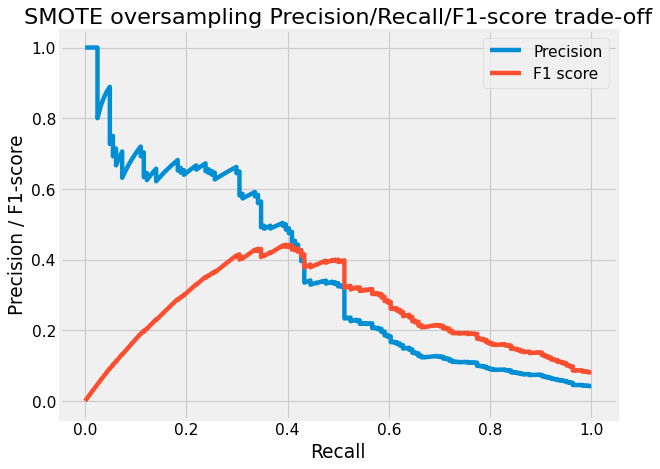

In [30]:
plot_precision = smote_models[0.2]["precision"]
plot_recall = smote_models[0.2]["recall"]
plot_f1 = smote_models[0.2]["f1"]

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_ = plt.plot(plot_recall, plot_precision, label="Precision")
_ = plt.plot(plot_recall, plot_f1, label="F1 score")
_ = plt.xlabel("Recall")
_ = plt.ylabel("Precision / F1-score")
_ = plt.title("SMOTE oversampling Precision/Recall/F1-score trade-off")
_ = plt.legend()

## Oversampling - ADASYN <a id='ADASYN_oversampling'>

In [31]:
from imblearn.over_sampling import ADASYN

In [32]:
adasyn_models = {}
for adasyn_ratio in tqdm([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]):
    print(f"Running for ADASYN ratio: {adasyn_ratio}")
    adasyn = ADASYN(sampling_strategy=adasyn_ratio, random_state=42)
    cls, precision, recall, f1 = run_single_experiment(adasyn, X_train, y_train_low_pop, X_test, y_test_low_pop)
    adasyn_models[adasyn_ratio] = {
        "cls": cls,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
    print()

  0%|          | 0/9 [00:00<?, ?it/s]

Running for ADASYN ratio: 0.1


,Precision,Recall,F1-score,Threshold
3540,0.514019,0.335366,0.405904,0.500932
3539,0.509259,0.335366,0.404412,0.500566
3538,0.504587,0.335366,0.402930,0.500190
3533,0.491228,0.341463,0.402878,0.479250
3542,0.514286,0.329268,0.401487,0.504930



Running for ADASYN ratio: 0.15


,Precision,Recall,F1-score,Threshold
3668,0.581395,0.304878,0.400000,0.640995
3637,0.478632,0.341463,0.398577,0.549590
3642,0.491071,0.335366,0.398551,0.557749
3667,0.574713,0.304878,0.398406,0.635356
3606,0.418919,0.378049,0.397436,0.475340



Running for ADASYN ratio: 0.2


,Precision,Recall,F1-score,Threshold
3609,0.452555,0.378049,0.411960,0.577832
3618,0.468750,0.365854,0.410959,0.599067
3613,0.458647,0.371951,0.410774,0.586249
3617,0.465116,0.365854,0.409556,0.598010
3612,0.455224,0.371951,0.409396,0.585298



Running for ADASYN ratio: 0.25


,Precision,Recall,F1-score,Threshold
3630,0.513761,0.341463,0.410256,0.677396
3629,0.509091,0.341463,0.408759,0.676049
3643,0.552083,0.323171,0.407692,0.713165
3628,0.504505,0.341463,0.407273,0.674625
3642,0.546392,0.323171,0.406130,0.712380



Running for ADASYN ratio: 0.3


,Precision,Recall,F1-score,Threshold
3667,0.534653,0.329268,0.407547,0.749148
3666,0.529412,0.329268,0.406015,0.741818
3665,0.524272,0.329268,0.404494,0.741060
3669,0.535354,0.323171,0.403042,0.755712
3664,0.519231,0.329268,0.402985,0.739688



Running for ADASYN ratio: 0.35


,Precision,Recall,F1-score,Threshold
3657,0.464567,0.359756,0.405498,0.694628
3656,0.460938,0.359756,0.404110,0.690711
3655,0.457364,0.359756,0.402730,0.689504
3659,0.464000,0.353659,0.401384,0.696552
3654,0.453846,0.359756,0.401361,0.687691



Running for ADASYN ratio: 0.4


,Precision,Recall,F1-score,Threshold
3670,0.401361,0.359756,0.379421,0.689301
3669,0.398649,0.359756,0.378205,0.687906
3668,0.395973,0.359756,0.376997,0.686668
3689,0.429688,0.335366,0.376712,0.717808
3683,0.417910,0.341463,0.375839,0.712513



Running for ADASYN ratio: 0.45


,Precision,Recall,F1-score,Threshold
3732,0.491228,0.341463,0.402878,0.772361
3731,0.486957,0.341463,0.401434,0.772359
3730,0.482759,0.341463,0.400000,0.772039
3735,0.495495,0.335366,0.400000,0.779434
3729,0.478632,0.341463,0.398577,0.769989



Running for ADASYN ratio: 0.5


,Precision,Recall,F1-score,Threshold
3664,0.426471,0.353659,0.386667,0.755723
3663,0.423358,0.353659,0.385382,0.755479
3673,0.440945,0.341463,0.384880,0.777350
3662,0.420290,0.353659,0.384106,0.754486
3667,0.428571,0.347561,0.383838,0.761717


The best model was trained on the data that was "balanced" to the `20%` mark (as with SMOTE). However, results are worse. Results of the best threshold (`0.578`): Precision - `0.453`; Recall - `0.378`; F1 - `0.412`

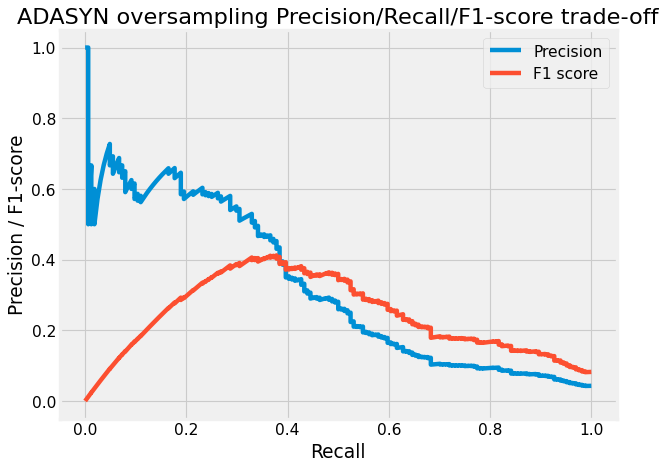

In [33]:
plot_precision = adasyn_models[0.2]["precision"]
plot_recall = adasyn_models[0.2]["recall"]
plot_f1 = adasyn_models[0.2]["f1"]

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_ = plt.plot(plot_recall, plot_precision, label="Precision")
_ = plt.plot(plot_recall, plot_f1, label="F1 score")
_ = plt.xlabel("Recall")
_ = plt.ylabel("Precision / F1-score")
_ = plt.title("ADASYN oversampling Precision/Recall/F1-score trade-off")
_ = plt.legend()

## Ensemble <a id='ensemble'>

In [34]:
from imblearn.ensemble import BalancedBaggingClassifier

In [35]:
ensemble_models = {}
for n_cls in tqdm(range(10, 51, 5)):
    print(f"Running for Ensemble with {n_cls} classifiers")
    cls = BalancedBaggingClassifier(
        n_estimators=n_cls,
        replacement=True,
        random_state=42
    )
    cls.fit(X_train, y_train_low_pop)
    preds = cls.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test_low_pop, preds)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        f1score = 2 * (precision * recall) / (precision + recall)
    display_top_f1_scores(precision, recall, f1score, thresholds)
    
    ensemble_models[n_cls] = {
        "cls": cls,
        "precision": precision,
        "recall": recall,
        "f1": f1score,
    }
    print()

  0%|          | 0/9 [00:00<?, ?it/s]

Running for Ensemble with 10 classifiers


,Precision,Recall,F1-score,Threshold
18,0.398844,0.420732,0.409496,0.80
20,0.519608,0.323171,0.398496,0.90
19,0.509615,0.323171,0.395522,0.85
14,0.312057,0.536585,0.394619,0.65
17,0.311828,0.530488,0.392777,0.70



Running for Ensemble with 15 classifiers


,Precision,Recall,F1-score,Threshold
25,0.386473,0.487805,0.431267,0.733333
24,0.382775,0.487805,0.428954,0.700000
26,0.440000,0.402439,0.420382,0.766667
27,0.436242,0.396341,0.415335,0.800000
23,0.313380,0.542683,0.397321,0.666667



Running for Ensemble with 20 classifiers


,Precision,Recall,F1-score,Threshold
41,0.450292,0.469512,0.459701,0.750
40,0.447674,0.469512,0.458333,0.725
43,0.511450,0.408537,0.454237,0.800
42,0.507576,0.408537,0.452703,0.775
37,0.391705,0.518293,0.446194,0.675



Running for Ensemble with 25 classifiers


,Precision,Recall,F1-score,Threshold
45,0.474026,0.445122,0.459119,0.76
44,0.470968,0.445122,0.457680,0.74
47,0.533333,0.390244,0.450704,0.80
46,0.528926,0.390244,0.449123,0.78
43,0.406091,0.487805,0.443213,0.72



Running for Ensemble with 30 classifiers


,Precision,Recall,F1-score,Threshold
48,0.412621,0.518293,0.459459,0.700000
47,0.410628,0.518293,0.458221,0.683333
52,0.568807,0.378049,0.454212,0.800000
51,0.496350,0.414634,0.451827,0.766667
50,0.492754,0.414634,0.450331,0.750000



Running for Ensemble with 35 classifiers


,Precision,Recall,F1-score,Threshold
56,0.487013,0.457317,0.471698,0.742857
54,0.433862,0.500000,0.464589,0.700000
55,0.433155,0.493902,0.461538,0.714286
57,0.511450,0.408537,0.454237,0.771429
58,0.568807,0.378049,0.454212,0.800000



Running for Ensemble with 40 classifiers


,Precision,Recall,F1-score,Threshold
62,0.486667,0.445122,0.464968,0.7500
59,0.448864,0.481707,0.464706,0.7125
58,0.424242,0.512195,0.464088,0.7000
61,0.483444,0.445122,0.463492,0.7375
60,0.448276,0.475610,0.461538,0.7250



Running for Ensemble with 45 classifiers


,Precision,Recall,F1-score,Threshold
74,0.481250,0.469512,0.475309,0.733333
73,0.448087,0.500000,0.472622,0.711111
71,0.421053,0.536585,0.471850,0.688889
72,0.445652,0.500000,0.471264,0.700000
79,0.577982,0.384146,0.461538,0.800000



Running for Ensemble with 50 classifiers


,Precision,Recall,F1-score,Threshold
80,0.525926,0.432927,0.474916,0.75
81,0.522388,0.426829,0.469799,0.76
79,0.480519,0.451220,0.465409,0.74
76,0.424242,0.512195,0.464088,0.70
78,0.477419,0.451220,0.463950,0.73


The best ensemble contained `45` models in it. Results of the best threshold (`0.733`): Precision - `0.481`; Recall - `0.470`; F1 - `0.475`

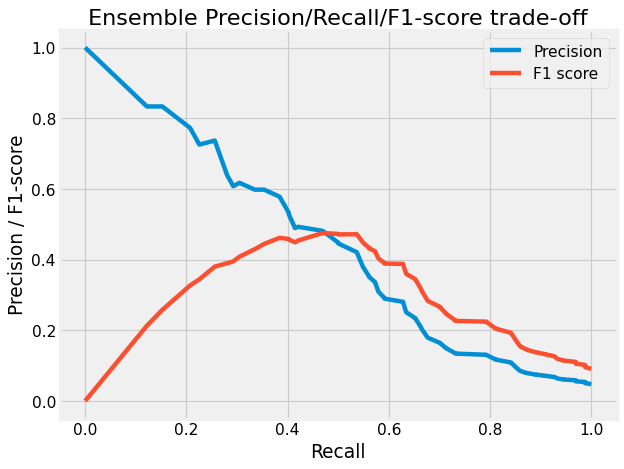

In [36]:
plot_precision = ensemble_models[45]["precision"]
plot_recall = ensemble_models[45]["recall"]
plot_f1 = ensemble_models[45]["f1"]

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_ = plt.plot(plot_recall, plot_precision, label="Precision")
_ = plt.plot(plot_recall, plot_f1, label="F1 score")
_ = plt.xlabel("Recall")
_ = plt.ylabel("Precision / F1-score")
_ = plt.title("Ensemble Precision/Recall/F1-score trade-off")
_ = plt.legend()

# Results overview <a id='results'>

Bellow are the best performing models (with their respective thresholds) from each approach:

| Approach | Precision | Recall | F1-Score | Notes |
| -------- | --------- | ------ | -------- | ----- |
| Weighting training examples | 0.524 | 0.457 | 0.489 | Best performing weighting at 7-to-1; threshold - 0.545 |
| Random undersampling | 0.469 | 0.500 | 0.484 | Best performing undersampling to 20/80; threshold - 0.423 |
| Ensemble | 0.481 | 0.470 | 0.475 | Best performing ensemble was with 45 models; threshold - 0.733 |
| Naive | 0.564 | 0.402 | 0.470 | Threshold - 0.205 |
| SMOTE oversampling | 0.500 | 0.396 | 0.442 | Best performing oversampling at 20/80; threshold - 0.567 |
| ADASYN oversampling | 0.453 | 0.378 | 0.412 | Best performing oversampling at 20/80; threshold - 0.578 |
| NearMiss undersampling | 0.483 | 0.341 | 0.400 | Best performing undersampling was done with version 3 to 50/50; threshold - 0.692 |


## "Cleaned" training dataset

### With Class Weights Model

In [37]:
train_preds =  class_weights_results[7]["cls"].predict_proba(X_train)[:, 1]
train_preds_remain = (train_preds < 0.545446)

In [38]:
y_train_cleaned = y_train.loc[train_preds_remain]


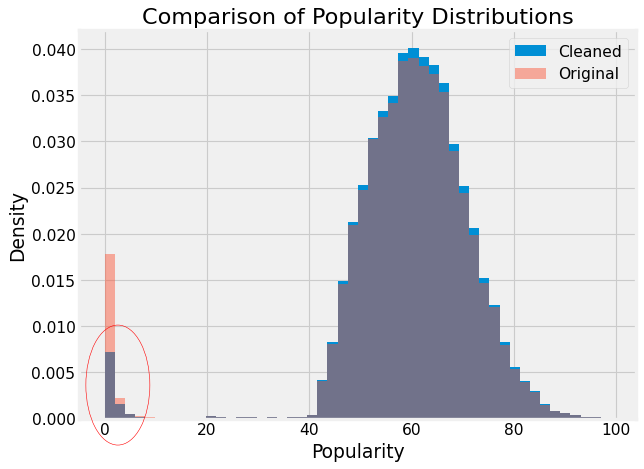

In [39]:
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_1, bins, _ = plt.hist(y_train_cleaned.to_list(), bins=50, density=True, label="Cleaned")
_11, _, _ = plt.hist(y_train.to_list(), bins=bins, alpha=0.45, density=True, label="Original")
e = Ellipse(xy=(0.14,0.14), width=0.1, height=0.25)
e.set_edgecolor("red")
e.set_facecolor("none")
e.set_alpha(1)
fig.add_artist(e)
_ = plt.title("Comparison of Popularity Distributions")
_ = plt.xlabel("Popularity")
_ = plt.ylabel("Density")
_ = plt.legend()

In [40]:
print(f"We have {(1 - (_1[0]/_11[0]))*100:0.2f} percent fewer low scores in `cleaned` dataset")

We have 59.39 percent fewer low scores in `cleaned` dataset


### With Randomly Undersampled Molde

In [41]:
train_preds =  random_sample_models[0.2]["cls"].predict_proba(X_train)[:, 1]
train_preds_remain = (train_preds < 0.423348)

In [42]:
y_train_cleaned_2 = y_train.loc[train_preds_remain]

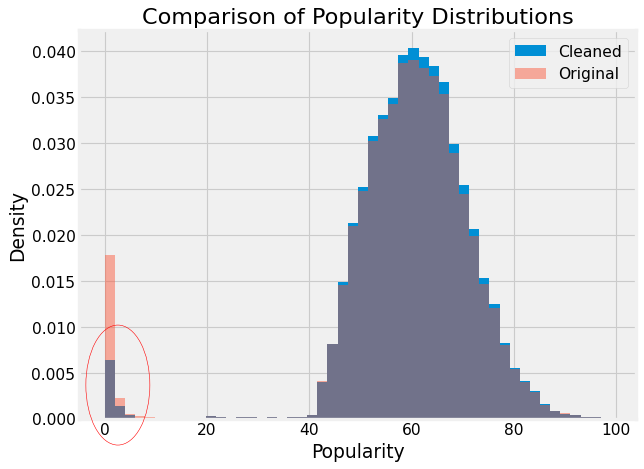

In [43]:
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_1, bins, _2 = plt.hist(y_train_cleaned_2.to_list(), bins=50, density=True, label="Cleaned")
_11, _, _21 = plt.hist(y_train.to_list(), bins=bins, alpha=0.45, density=True, label="Original")
e = Ellipse(xy=(0.14,0.14), width=0.1, height=0.25)
e.set_edgecolor("red")
e.set_facecolor("none")
e.set_alpha(1)
fig.add_artist(e)
_ = plt.title("Comparison of Popularity Distributions")
_ = plt.xlabel("Popularity")
_ = plt.ylabel("Density")
_ = plt.legend()

In [44]:
print(f"We have {(1 - (_1[0]/_11[0]))*100:0.2f} percent fewr low scores in `cleaned` dataset")

We have 64.33 percent fewr low scores in `cleaned` dataset
